In [1]:
# What version of Python do you have?
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.3.1-arm64-arm-64bit
PyTorch Version: 2.1.0.dev20230430

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 2.0.1
Scikit-Learn 1.2.2
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [2]:
crime_binary = pd.read_csv("./Crime+Corpus/crimes_binary_v1.csv").drop("Unnamed: 0",axis=1)
crime_binary.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Updated On,Latitude,Longitude,Location,Community Area Name,Dristrict-Name,SocioEconomic-Status,Hour,Day,Month
0,11515814,JB527247,2018-01-01 01:00:00,023XX S HOMAN AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,False,...,11/28/2018 04:14:58 PM,41.849030,-87.710045,"(41.849030217, -87.710044807)",South Lawndale,Ogden,High Income,1,1,1
1,11210595,JB125173,2018-01-01 01:00:00,007XX W GRACE ST,0890,THEFT,FROM BUILDING,APARTMENT,False,False,...,05/04/2018 03:51:04 PM,41.951457,-87.648582,"(41.951457303, -87.648582038)",Lake View,Town Hall,Low Income,1,1,1
2,11205233,JB117580,2018-01-01 01:00:00,006XX W HUTCHINSON ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,...,05/04/2018 03:51:04 PM,41.959354,-87.646931,"(41.95935351, -87.64693126)",Uptown,Town Hall,Moderate Income,1,1,1


In [3]:
crime_binary['Date'] = pd.to_datetime(crime_binary['Date'])
crime_binary['dayofweek'] = crime_binary["Date"].dt.strftime("%a")
crime_binary['dayofweek']

0          Mon
1          Mon
2          Mon
3          Mon
4          Mon
          ... 
1175724    Sat
1175725    Sat
1175726    Sat
1175727    Sat
1175728    Sat
Name: dayofweek, Length: 1175729, dtype: object

In [4]:
### Incarceration Data
crime_arrest = crime_binary.copy(deep=True)

# select features and target variable
features = ['Block','Primary Type', 'Description','Community Area','Location Description','SocioEconomic-Status','dayofweek']
target = 'Arrest'

# encode categorical features
for feature in features:
    if crime_arrest[feature].dtype == 'object':
        crime_arrest[feature] = pd.factorize(crime_arrest[feature])[0]
        
crime_arrest

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Latitude,Longitude,Location,Community Area Name,Dristrict-Name,SocioEconomic-Status,Hour,Day,Month,dayofweek
0,11515814,JB527247,2018-01-01 01:00:00,0,0560,0,0,0,False,False,...,41.849030,-87.710045,"(41.849030217, -87.710044807)",South Lawndale,Ogden,0,1,1,1,0
1,11210595,JB125173,2018-01-01 01:00:00,1,0890,1,1,0,False,False,...,41.951457,-87.648582,"(41.951457303, -87.648582038)",Lake View,Town Hall,1,1,1,1,0
2,11205233,JB117580,2018-01-01 01:00:00,2,0281,2,2,1,False,True,...,41.959354,-87.646931,"(41.95935351, -87.64693126)",Uptown,Town Hall,2,1,1,1,0
3,11192281,JB100080,2018-01-01 01:00:00,3,0486,3,3,2,True,True,...,41.653221,-87.545916,"(41.653220991, -87.54591594)",Hegewisch,South Chicago,2,1,1,1,0
4,11193559,JB100825,2018-01-01 01:00:00,4,0870,1,4,2,False,False,...,41.893677,-87.635628,"(41.893676531, -87.635628328)",Near North Side,Near North,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175724,12937789,JF528687,2022-12-31 12:45:00,12251,1310,7,13,13,False,False,...,41.874153,-87.735239,"(41.874153389, -87.735238688)",West Garfield Park,Harrison,0,12,31,12,4
1175725,12938029,JF528801,2022-12-31 12:50:00,3209,0560,0,0,0,False,False,...,41.855911,-87.719966,"(41.855911352, -87.719966)",North Lawndale,Ogden,0,12,31,12,4
1175726,12937822,JF528703,2022-12-31 12:50:00,364,051A,0,99,0,False,True,...,41.766546,-87.645669,"(41.766545786, -87.64566932)",Englewood,Englewood,0,12,31,12,4
1175727,12937583,JF528218,2022-12-31 00:52:00,19949,0460,3,0,43,False,False,...,41.868829,-87.686098,"(41.868829303, -87.686098247)",Near West Side,Harrison,2,0,31,12,4


In [6]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Downsampling and Normalizing
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = crime_arrest[features], crime_arrest[target]

print(f"Features {features}")
print(f'Class: {target}')

print(f'Class Balance: {y.value_counts()}')
smote_enn = SMOTEENN(random_state=42,)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

print('- Undersampling Data.')

print('Class distribution after undersampling:')
print(pd.Series(y_resampled).value_counts())

print('Scaling Numericals')
# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler on the data
scaler.fit(X)

# transform the data using the scaler
X_scaled = scaler.transform(X_resampled)


Features ['Block', 'Primary Type', 'Description', 'Community Area', 'Location Description', 'SocioEconomic-Status', 'dayofweek']
Class: Arrest
Class Balance: Arrest
False    980840
True     194889
Name: count, dtype: int64
- Undersampling Data.
Class distribution after undersampling:
Arrest
True     720877
False    645523
Name: count, dtype: int64
Scaling Numericals


In [8]:
# Sampling 
data = pd.DataFrame(X_scaled)
data['target'] = y_resampled
data = data.sample(10000)
X = data.drop('target',axis=1)
y = data['target']

print(f'Creating Distributions Train: 70, Test: 30')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=101)


Creating Distributions Train: 70, Test: 30


In [9]:
data = pd.

,0,1,2,3,4,5,6
204291,-0.957059,0.460431,-0.439639,0.566682,-0.601573,0.920516,0.001433
198042,-0.934677,-0.227957,-0.581219,-1.107446,0.319626,0.920516,0.001433
527826,-0.841103,0.230968,-0.545824,0.334165,-0.555513,0.920516,1.508935
48687,-1.186813,-0.457419,-0.669706,0.055143,-0.555513,0.920516,-1.003569
89765,0.066454,0.460431,-0.439639,1.124725,-0.140974,-1.440874,1.006434
...,...,...,...,...,...,...,...
834311,0.862101,-0.457419,-0.616614,0.752697,-0.555513,0.920516,-0.501068
292073,-1.090138,-0.916345,-0.652008,-1.339963,-0.371273,-0.260179,-1.506070
502311,1.006641,-0.457419,-0.616614,-0.828424,-0.463393,0.920516,1.006434
979917,-1.141779,0.689893,0.516023,0.427172,1.701425,0.920516,0.503934


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Define the dataset class
class BinaryDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values.reshape(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.Tensor(self.data[idx])
        y = torch.Tensor(self.target[idx])
        return x, y

# Load the data
df = data.copy(deep=True)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Create the datasets and data loaders
train_dataset = BinaryDataset(train_df)
test_dataset = BinaryDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the hyperparameters
input_dim = df.shape[1] - 1
hidden_dim = 3
output_dim = 1
lr = 0.001
num_epochs = 200

# lists to record metrics
train_loss_records = []
test_loss_records = []
train_acc_records = []
test_acc_records = []

# Initialize the model and optimizer
model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        train_acc += torch.sum(preds == targets).item()
    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

    # Evaluate the model on the test set
    test_loss = 0.0
    test_acc = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            test_acc += torch.sum(preds == targets).item()
    test_loss /= len(test_loader)
    test_acc /= len(test_dataset)
    
    train_loss_records.append(train_loss)
    train_acc_records.append(train_acc)
    test_loss_records.append(test_loss)
    test_acc_records.append(test_acc)

    # Print the epoch statistics
    print("Epoch {}/{}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}, Test Loss: {:.4f},".format(epoch+1,num_epochs, train_loss, train_acc, test_loss, test_acc))
    #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, 
          #Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/200, Train Loss: 0.6895, Train Acc: 0.5292, Test Acc: 0.6478, Test Loss: 0.6315,
Epoch 2/200, Train Loss: 0.6155, Train Acc: 0.6757, Test Acc: 0.5858, Test Loss: 0.7070,
Epoch 3/200, Train Loss: 0.5727, Train Acc: 0.7268, Test Acc: 0.5586, Test Loss: 0.7300,
Epoch 4/200, Train Loss: 0.5567, Train Acc: 0.7389, Test Acc: 0.5499, Test Loss: 0.7345,
Epoch 5/200, Train Loss: 0.5523, Train Acc: 0.7409, Test Acc: 0.5480, Test Loss: 0.7345,
Epoch 6/200, Train Loss: 0.5511, Train Acc: 0.7399, Test Acc: 0.5476, Test Loss: 0.7350,
Epoch 7/200, Train Loss: 0.5505, Train Acc: 0.7384, Test Acc: 0.5471, Test Loss: 0.7345,
Epoch 8/200, Train Loss: 0.5500, Train Acc: 0.7380, Test Acc: 0.5468, Test Loss: 0.7340,
Epoch 9/200, Train Loss: 0.5497, Train Acc: 0.7401, Test Acc: 0.5467, Test Loss: 0.7350,
Epoch 10/200, Train Loss: 0.5494, Train Acc: 0.7374, Test Acc: 0.5463, Test Loss: 0.7355,
Epoch 11/200, Train Loss: 0.5489, Train Acc: 0.7380, Test Acc: 0.5461, Test Loss: 0.7350,
Epoch 12/200, Train

Epoch 93/200, Train Loss: 0.5411, Train Acc: 0.7346, Test Acc: 0.5405, Test Loss: 0.7295,
Epoch 94/200, Train Loss: 0.5412, Train Acc: 0.7348, Test Acc: 0.5404, Test Loss: 0.7290,
Epoch 95/200, Train Loss: 0.5411, Train Acc: 0.7366, Test Acc: 0.5403, Test Loss: 0.7270,
Epoch 96/200, Train Loss: 0.5409, Train Acc: 0.7352, Test Acc: 0.5402, Test Loss: 0.7270,
Epoch 97/200, Train Loss: 0.5410, Train Acc: 0.7355, Test Acc: 0.5405, Test Loss: 0.7290,
Epoch 98/200, Train Loss: 0.5410, Train Acc: 0.7359, Test Acc: 0.5402, Test Loss: 0.7265,
Epoch 99/200, Train Loss: 0.5410, Train Acc: 0.7355, Test Acc: 0.5402, Test Loss: 0.7290,
Epoch 100/200, Train Loss: 0.5411, Train Acc: 0.7350, Test Acc: 0.5404, Test Loss: 0.7305,
Epoch 101/200, Train Loss: 0.5409, Train Acc: 0.7354, Test Acc: 0.5403, Test Loss: 0.7295,
Epoch 102/200, Train Loss: 0.5409, Train Acc: 0.7358, Test Acc: 0.5404, Test Loss: 0.7295,
Epoch 103/200, Train Loss: 0.5409, Train Acc: 0.7351, Test Acc: 0.5400, Test Loss: 0.7265,
Epoch 

Epoch 186/200, Train Loss: 0.5362, Train Acc: 0.7365, Test Acc: 0.5358, Test Loss: 0.7260,
Epoch 187/200, Train Loss: 0.5363, Train Acc: 0.7365, Test Acc: 0.5356, Test Loss: 0.7255,
Epoch 188/200, Train Loss: 0.5363, Train Acc: 0.7360, Test Acc: 0.5356, Test Loss: 0.7255,
Epoch 189/200, Train Loss: 0.5361, Train Acc: 0.7355, Test Acc: 0.5359, Test Loss: 0.7290,
Epoch 190/200, Train Loss: 0.5362, Train Acc: 0.7380, Test Acc: 0.5356, Test Loss: 0.7260,
Epoch 191/200, Train Loss: 0.5363, Train Acc: 0.7365, Test Acc: 0.5361, Test Loss: 0.7275,
Epoch 192/200, Train Loss: 0.5363, Train Acc: 0.7351, Test Acc: 0.5359, Test Loss: 0.7260,
Epoch 193/200, Train Loss: 0.5363, Train Acc: 0.7359, Test Acc: 0.5361, Test Loss: 0.7280,
Epoch 194/200, Train Loss: 0.5363, Train Acc: 0.7370, Test Acc: 0.5358, Test Loss: 0.7275,
Epoch 195/200, Train Loss: 0.5361, Train Acc: 0.7356, Test Acc: 0.5361, Test Loss: 0.7280,
Epoch 196/200, Train Loss: 0.5363, Train Acc: 0.7374, Test Acc: 0.5357, Test Loss: 0.7265,

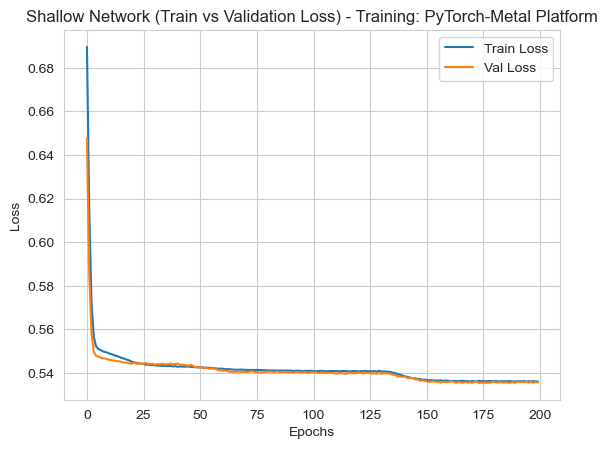

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')

plt.plot(range(200), train_loss_records,label='Train Loss')
plt.plot(range(200), test_loss_records,label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Shallow Network (Train vs Validation Loss) - Training: PyTorch-Metal Platform')
plt.legend()


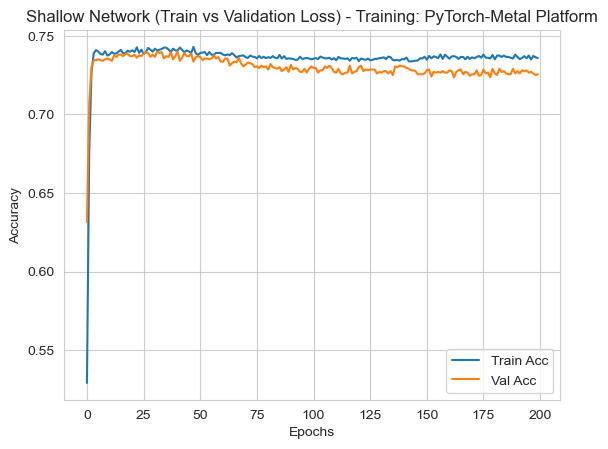

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')

plt.plot(range(200), train_acc_records,label='Train Acc')
plt.plot(range(200), test_acc_records,label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Shallow Network (Train vs Validation Loss) - Training: PyTorch-Metal Platform')
plt.legend()
